Device: cuda


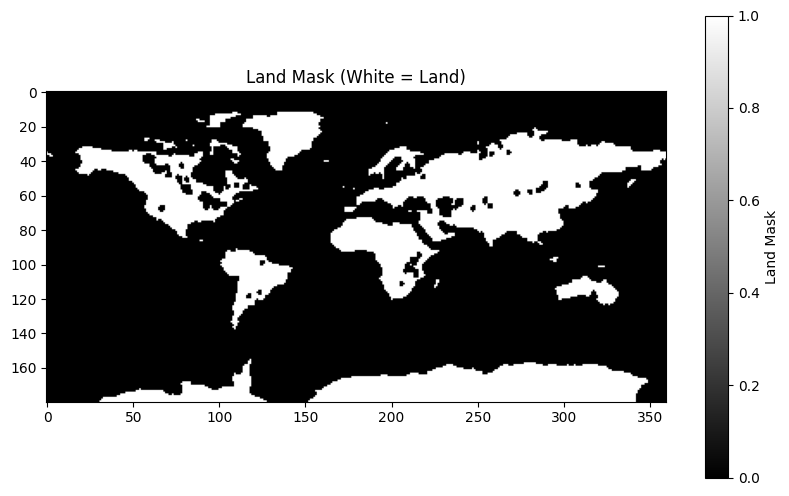

Land mask shape: (180, 360)


/tmp/ipykernel_3418617/3834673045.py:59: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32).unsqueeze(1)



Starting experiment: attn_activation=sigmoid, lr=0.001, dropout=0.2
Epoch 1: Train Loss = 123.0165, Test Spearman Correlation = 0.2815
Epoch 2: Train Loss = 96.6025, Test Spearman Correlation = 0.6005
Epoch 3: Train Loss = 75.1564, Test Spearman Correlation = 0.6997
Epoch 4: Train Loss = 61.0018, Test Spearman Correlation = 0.7618
Epoch 5: Train Loss = 52.0374, Test Spearman Correlation = 0.7854
Epoch 6: Train Loss = 43.8266, Test Spearman Correlation = 0.8061
Epoch 7: Train Loss = 38.0638, Test Spearman Correlation = 0.8218
Epoch 8: Train Loss = 34.3818, Test Spearman Correlation = 0.8261
Epoch 9: Train Loss = 30.8049, Test Spearman Correlation = 0.8388
Epoch 10: Train Loss = 28.6327, Test Spearman Correlation = 0.8486
Epoch 11: Train Loss = 26.5257, Test Spearman Correlation = 0.8579
Epoch 12: Train Loss = 25.1613, Test Spearman Correlation = 0.8687
Epoch 13: Train Loss = 23.0556, Test Spearman Correlation = 0.8755
Epoch 14: Train Loss = 22.1721, Test Spearman Correlation = 0.8807
E

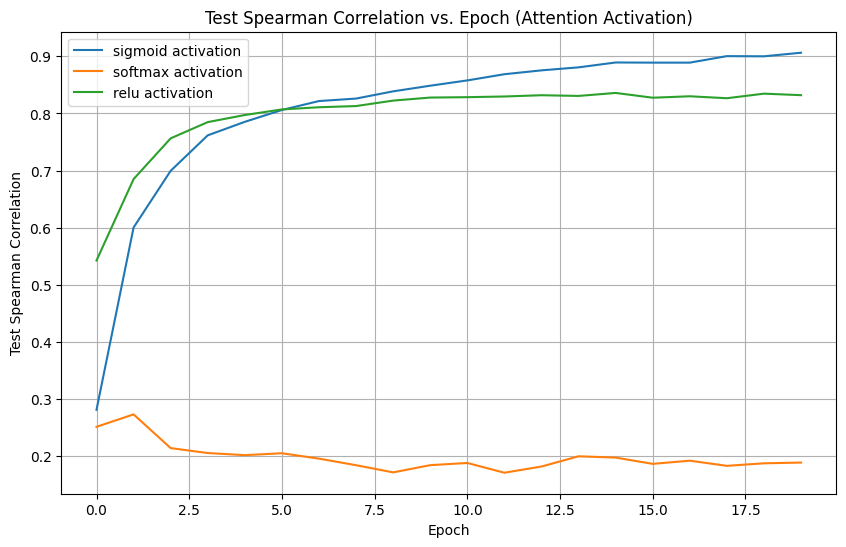


Starting experiment: attn_activation=sigmoid, lr=1e-05, dropout=0.2
Epoch 1: Train Loss = 173.1338, Test Spearman Correlation = 0.1178
Epoch 2: Train Loss = 172.5065, Test Spearman Correlation = 0.1434
Epoch 3: Train Loss = 166.7753, Test Spearman Correlation = 0.1255
Epoch 4: Train Loss = 155.5063, Test Spearman Correlation = 0.1464
Epoch 5: Train Loss = 146.0249, Test Spearman Correlation = 0.1897
Epoch 6: Train Loss = 137.9191, Test Spearman Correlation = 0.2225
Epoch 7: Train Loss = 133.3024, Test Spearman Correlation = 0.2268
Epoch 8: Train Loss = 129.9650, Test Spearman Correlation = 0.2240
Epoch 9: Train Loss = 127.5435, Test Spearman Correlation = 0.2244
Epoch 10: Train Loss = 125.6987, Test Spearman Correlation = 0.2261
Epoch 11: Train Loss = 124.1089, Test Spearman Correlation = 0.2293
Epoch 12: Train Loss = 122.9896, Test Spearman Correlation = 0.2334
Epoch 13: Train Loss = 121.8533, Test Spearman Correlation = 0.2361
Epoch 14: Train Loss = 121.1814, Test Spearman Correlati

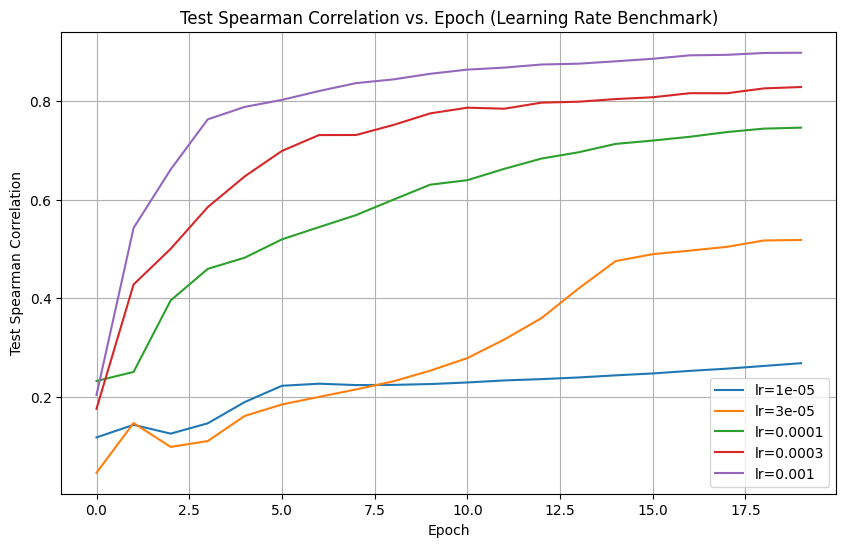


Starting experiment: attn_activation=sigmoid, lr=0.001, dropout=0
Epoch 1: Train Loss = 122.1962, Test Spearman Correlation = 0.3537
Epoch 2: Train Loss = 93.8311, Test Spearman Correlation = 0.6190
Epoch 3: Train Loss = 69.9641, Test Spearman Correlation = 0.7507
Epoch 4: Train Loss = 49.9805, Test Spearman Correlation = 0.7907
Epoch 5: Train Loss = 36.9004, Test Spearman Correlation = 0.8088
Epoch 6: Train Loss = 29.5417, Test Spearman Correlation = 0.8336
Epoch 7: Train Loss = 25.7176, Test Spearman Correlation = 0.8390
Epoch 8: Train Loss = 22.7762, Test Spearman Correlation = 0.8513
Epoch 9: Train Loss = 19.8404, Test Spearman Correlation = 0.8705
Epoch 10: Train Loss = 17.6024, Test Spearman Correlation = 0.8797
Epoch 11: Train Loss = 16.8523, Test Spearman Correlation = 0.8839
Epoch 12: Train Loss = 15.4439, Test Spearman Correlation = 0.8927
Epoch 13: Train Loss = 14.9147, Test Spearman Correlation = 0.8946
Epoch 14: Train Loss = 14.1060, Test Spearman Correlation = 0.8932
Epo

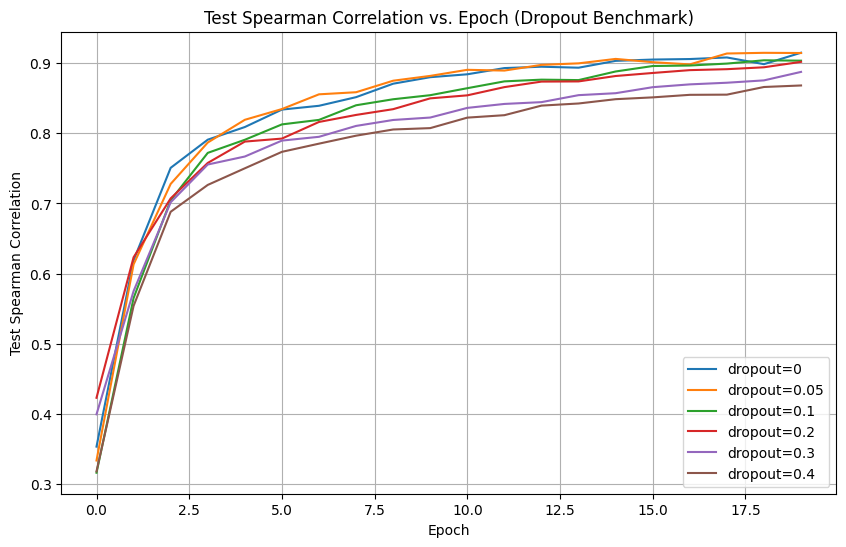

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr
from skimage.transform import resize

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ============ Data Preprocessing ============
sequence_len = 3

class OceanDataset(Dataset):
    def __init__(self, file_paths, land_mask, sequence_length=sequence_len):
        self.sequence_length = sequence_length
        self.land_mask = land_mask
        self.features, self.targets = self.load_data(file_paths)

    def load_data(self, file_paths):
        def read_var(path, var):
            data = netCDF4.Dataset(path)[var][:].filled(np.nan)
            return data

        SSH = read_var(file_paths['SSH'], 'SSH')
        SST = read_var(file_paths['SST'], 'SST')
        uSSW = read_var(file_paths['uSSW'], 'uSSW')
        vSSW = read_var(file_paths['vSSW'], 'vSSW')
        ST = read_var(file_paths['depth1'], 'ST')

        SSH = resize(SSH, (SSH.shape[0], 180, 360), preserve_range=True)
        SST = resize(SST, (SST.shape[0], 180, 360), preserve_range=True)
        uSSW = resize(uSSW, (uSSW.shape[0], 180, 360), preserve_range=True)
        vSSW = resize(vSSW, (vSSW.shape[0], 180, 360), preserve_range=True)
        ST = resize(ST, (ST.shape[0], 180, 360), preserve_range=True)

        X = np.stack([SSH, SST, uSSW, vSSW], axis=1)
        y = ST

        X = np.nan_to_num(X)
        y = np.nan_to_num(y)

        scaler = StandardScaler()
        T, C, H, W = X.shape
        X = X.reshape(T, -1)
        X = scaler.fit_transform(X).reshape(T, C, H, W)

        inputs, targets = [], []
        for i in range(self.sequence_length, T):
            inputs.append(X[i - self.sequence_length:i])
            targets.append(y[i])

        return torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# ============ Spatial Attention Module ============
class SpatialAttention(nn.Module):
    def __init__(self, in_channels, activation='sigmoid'):
        """
        activation: one of 'sigmoid', 'softmax', or 'relu'
        """
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.activation = activation

    def forward(self, x):
        attn_scores = self.conv(x)
        if self.activation == 'sigmoid':
            attn = torch.sigmoid(attn_scores)
        elif self.activation == 'softmax':
            # Flatten spatial dimensions and apply softmax to distribute attention over HxW
            B, C, H, W = attn_scores.shape
            attn = attn_scores.view(B, -1)
            attn = torch.softmax(attn, dim=1)
            attn = attn.view(B, C, H, W)
        elif self.activation == 'relu':
            attn = torch.relu(attn_scores)
        else:
            raise ValueError("Invalid activation function provided.")
        return x * attn

# ============ Modified ConvLSTM Cell with Dropout and Residual Connection ============
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, dropout_prob=0.2):
        super(ConvLSTMCell, self).__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(input_dim + hidden_dim, 4 * hidden_dim, kernel_size, padding=padding)
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout2d(dropout_prob)

    def forward(self, x, h_prev, c_prev):
        # Concatenate the current input and previous hidden state
        combined = torch.cat([x, h_prev], dim=1)
        conv_output = self.conv(combined)
        # Split the convolution output into four parts for the gates
        cc_i, cc_f, cc_o, cc_g = torch.chunk(conv_output, 4, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        # Update cell and hidden state
        c = f * c_prev + i * g
        h = o * torch.tanh(c)
        # Apply dropout to the hidden state for regularization
        h = self.dropout(h)
        return h, c

# ============ Modified ConvLSTM Model with Attention ============
class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, dropout_prob=0.2, attn_activation='sigmoid'):
        """
        attn_activation: activation function for the SpatialAttention module.
        dropout_prob: dropout probability in ConvLSTM cells.
        """
        super(ConvLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        
        # Stack ConvLSTM cells
        self.cells = nn.ModuleList([
            ConvLSTMCell(input_dim if i == 0 else hidden_dim, hidden_dim, kernel_size, dropout_prob=dropout_prob)
            for i in range(num_layers)
        ])
        # Output mapping layer: maps the final hidden state to one channel (e.g., temperature)
        self.conv_out = nn.Conv2d(hidden_dim, 1, kernel_size=1)
        # Spatial attention applied on the final hidden state
        self.attn = SpatialAttention(hidden_dim, activation=attn_activation)

    def forward(self, x):
        # x has shape (B, T, C, H, W)
        B, T, C, H, W = x.size()
        # Initialize hidden and cell states for each layer
        h = [torch.zeros(B, self.hidden_dim, H, W, device=x.device) for _ in range(self.num_layers)]
        c = [torch.zeros(B, self.hidden_dim, H, W, device=x.device) for _ in range(self.num_layers)]

        for t in range(T):
            inp = x[:, t]  # input at current time step
            for i, cell in enumerate(self.cells):
                h_prev, c_prev = h[i], c[i]
                h[i], c[i] = cell(inp, h_prev, c_prev)
                # Residual connection when dimensions match
                if inp.shape[1] == self.hidden_dim:
                    h[i] = h[i] + inp
                inp = h[i]

        # Apply spatial attention on the final layer's hidden state.
        h_attn = self.attn(h[-1])
        # Map to output channel (temperature field)
        return self.conv_out(h_attn)

# ============ Training and Evaluation Functions ============
def train_model(model, train_loader, optimizer, criterion, land_mask, epoch, verbose=False):
    model.train()
    train_loss = 0
    # Prepare land mask (for broadcasting over batch dimension)
    land_mask_tensor = torch.tensor(land_mask, dtype=torch.bool).unsqueeze(0).unsqueeze(0).to(device)
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        B = outputs.size(0)
        land_mask_tensor_reshaped = land_mask_tensor.expand(B, -1, -1, -1)
        # Here, we assume land_mask==True represents land so we invert it for ocean pixels.
        ocean_mask = ~land_mask_tensor_reshaped
        loss_map = criterion(outputs[ocean_mask], targets[ocean_mask])
        loss = loss_map.mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    average_loss = train_loss / len(train_loader)
    if verbose:
        print(f"Epoch {epoch+1}: Training Loss = {average_loss:.4f}")
    return average_loss

def evaluate_model(model, test_loader, land_mask):
    model.eval()
    pred_list = []
    true_list = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            preds = model(inputs)
            pred_list.append(preds.cpu().numpy())
            true_list.append(targets.cpu().numpy())
            
    pred_array = np.concatenate(pred_list, axis=0)
    true_array = np.concatenate(true_list, axis=0)

    land_mask_bool = land_mask.astype(bool)
    spearman_scores = []
    for i in range(pred_array.shape[0]):
        pred = pred_array[i, 0]
        true = true_array[i, 0]
        # Invert land mask to consider only ocean pixels
        ocean_mask = ~land_mask_bool
        valid_preds = pred[ocean_mask]
        valid_true = true[ocean_mask]
        score, _ = spearmanr(valid_preds, valid_true)
        spearman_scores.append(score)
        
    return np.nanmean(spearman_scores)

def run_experiment_hyperparams(attn_activation, learning_rate, dropout_prob, train_loader, test_loader, land_mask, num_epochs=20):
    print(f"\nStarting experiment: attn_activation={attn_activation}, lr={learning_rate}, dropout={dropout_prob}")
    model = ConvLSTM(input_dim=4, hidden_dim=32, kernel_size=7, num_layers=2,
                     dropout_prob=dropout_prob, attn_activation=attn_activation)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss(reduction='none')

    train_losses = []
    test_scores = []
    for epoch in range(num_epochs):
        loss = train_model(model, train_loader, optimizer, criterion, land_mask, epoch)
        train_losses.append(loss)
        spearman = evaluate_model(model, test_loader, land_mask)
        test_scores.append(spearman)
        print(f"Epoch {epoch+1}: Train Loss = {loss:.4f}, Test Spearman Correlation = {spearman:.4f}")
    return train_losses, test_scores

# ============ Create binary land mask from SST data ============
def create_land_mask_2(st_file_path='project_SST_1992-2021.nc', shape=(180, 360)):
    ds = netCDF4.Dataset(st_file_path)
    st_data_full = ds.variables['SST'][:]  # (T, H, W)
    st_data_full = np.ma.filled(st_data_full, fill_value=0)
    resized_frames = [resize(frame, shape, preserve_range=True) for frame in st_data_full]
    st_resized_full = np.stack(resized_frames)
    st_mean = np.mean(st_resized_full, axis=0)
    land_mask = st_mean < 1e-3
    return land_mask

# Generate and plot the land mask
land_mask = create_land_mask_2()
plt.figure(figsize=(10, 6))
plt.imshow(np.flipud(land_mask), cmap='gray')
plt.title("Land Mask (White = Land)")
plt.colorbar(label='Land Mask')
plt.show()

print("Land mask shape:", land_mask.shape)

# ============ Dataset and DataLoader ============
file_paths = {
    'SSH': 'project_SSH_1992-2021.nc',
    'SST': 'project_SST_1992-2021.nc',
    'uSSW': 'project_uSSW_1992-2021.nc',
    'vSSW': 'project_vSSW_1992-2021.nc',
    'depth1': 'project_ST_1992-2021_dep-1.nc'
}

batch_size = 4

full_dataset = OceanDataset(file_paths, land_mask, sequence_length=sequence_len)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ============ Benchmarking Attention Activations (for reference) ============
activations = ['sigmoid', 'softmax', 'relu']
num_epochs = 20
activation_results = {}

for act in activations:
    train_loss, test_score = run_experiment_hyperparams(attn_activation=act, learning_rate=1e-3, dropout_prob=0.2,
                                                        train_loader=train_loader, test_loader=test_loader,
                                                        land_mask=land_mask, num_epochs=num_epochs)
    activation_results[act] = {'train_loss': train_loss, 'test_score': test_score}

plt.figure(figsize=(10, 6))
for act in activations:
    plt.plot(activation_results[act]['test_score'], label=f"{act} activation")
plt.xlabel("Epoch")
plt.ylabel("Test Spearman Correlation")
plt.title("Test Spearman Correlation vs. Epoch (Attention Activation)")
plt.legend()
plt.grid(True)
plt.show()

# ============ Benchmarking Learning Rates ============
learning_rates = [1e-5, 3e-5, 1e-4, 3e-4, 1e-3]
lr_results = {}

for lr in learning_rates:
    train_loss_lr, test_score_lr = run_experiment_hyperparams(attn_activation='sigmoid', learning_rate=lr, dropout_prob=0.2,
                                                              train_loader=train_loader, test_loader=test_loader,
                                                              land_mask=land_mask, num_epochs=num_epochs)
    lr_results[lr] = {'train_loss': train_loss_lr, 'test_score': test_score_lr}

plt.figure(figsize=(10, 6))
for lr in learning_rates:
    plt.plot(lr_results[lr]['test_score'], label=f"lr={lr}")
plt.xlabel("Epoch")
plt.ylabel("Test Spearman Correlation")
plt.title("Test Spearman Correlation vs. Epoch (Learning Rate Benchmark)")
plt.legend()
plt.grid(True)
plt.show()

# ============ Benchmarking Dropout Probabilities ============
dropout_probs = [0, 0.05, 0.1, 0.2, 0.3, 0.4]
dropout_results = {}

for dp in dropout_probs:
    train_loss_dp, test_score_dp = run_experiment_hyperparams(attn_activation='sigmoid', learning_rate=1e-3, dropout_prob=dp,
                                                              train_loader=train_loader, test_loader=test_loader,
                                                              land_mask=land_mask, num_epochs=num_epochs)
    dropout_results[dp] = {'train_loss': train_loss_dp, 'test_score': test_score_dp}

plt.figure(figsize=(10, 6))
for dp in dropout_probs:
    plt.plot(dropout_results[dp]['test_score'], label=f"dropout={dp}")
plt.xlabel("Epoch")
plt.ylabel("Test Spearman Correlation")
plt.title("Test Spearman Correlation vs. Epoch (Dropout Benchmark)")
plt.legend()
plt.grid(True)
plt.show()
